In [1]:
# Import statements
import glob
import pandas as pd

In [2]:
dfList = []
for file in sorted(glob.glob("./data/return-data/*")):
    one_day_df = pd.read_json(file, lines=True)
    dfList.append(one_day_df)
df = pd.concat(dfList).reset_index(drop=True)
df.shape

(31000, 5)

In [3]:
df.head()

,transactionId,basket,zipCode,totalAmount,returnLabel
0,2957385223,"[1, 3, 1, 5]",627,192,0
1,4890905342,"[4, 5, 5, 1, 3, 4]",959,96,0
2,3950059852,[4],625,67,0
3,9829252293,[2],368,93,0
4,6828748016,"[4, 4, 3]",575,171,0


## 1) Data Cleaning 

1. Basket = one hot encode with value number of occurences
2. Zip code = one hot encode. However, in real life create features for every number in the zipcode. i.e. 2000 would be the larger area. 2300 would be a smaller area. etc...

### 1.1) Check for nulls

In [4]:
# No nulls
df.isnull().sum()

transactionId    0
basket           0
zipCode          0
totalAmount      0
returnLabel      0
dtype: int64

### 1.2) Check for distribution in the target

In [5]:
df.loc[:, "returnLabel"].value_counts()

0    30711
1      289
Name: returnLabel, dtype: int64

### 1) TransactionId
- Drop since transactionId is unique and provides no predictive power

In [6]:
df_cleaned = df.drop("transactionId", axis=1)

### 2) Basket

In [7]:
# one hot encode the basket variable
df_basket_one_hot = df_cleaned.loc[:, 'basket'].map(lambda entry: { ('basket_' + str(e)):entry.count(e) for e in entry}).apply(pd.Series).fillna(0).astype('int')
df_cleaned = pd.concat([df_cleaned, df_basket_one_hot], axis=1).drop('basket', axis=1)

In [8]:
df_cleaned.head()

,zipCode,totalAmount,returnLabel,basket_1,basket_3,basket_5,basket_4,basket_2,basket_0
0,627,192,0,2,1,1,0,0,0
1,959,96,0,1,1,2,2,0,0
2,625,67,0,0,0,0,1,0,0
3,368,93,0,0,0,0,0,1,0
4,575,171,0,0,1,0,2,0,0


### 3) ZipCode
- one hot encode

In [9]:
df_cleaned['zipCode'] = pd.Categorical(df_cleaned['zipCode'], categories=list(range(100, 1001)))
df_zipcode_dummies = pd.get_dummies(df_cleaned.loc[:, 'zipCode'], prefix='zipcode')

In [10]:
df_cleaned = pd.concat([df_cleaned, df_zipcode_dummies], axis=1).drop('zipCode', axis=1)

In [11]:
df_cleaned

,totalAmount,returnLabel,basket_1,basket_3,basket_5,basket_4,basket_2,basket_0,zipcode_100,zipcode_101,...,zipcode_991,zipcode_992,zipcode_993,zipcode_994,zipcode_995,zipcode_996,zipcode_997,zipcode_998,zipcode_999,zipcode_1000
0,192,0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,0,1,1,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,171,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30995,630,0,3,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30996,312,0,1,2,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
30997,84,0,0,3,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30998,201,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4) totalAmount

In [12]:
df_cleaned.loc[:, 'totalAmount'].value_counts()

60      544
40      486
10      466
50      444
30      422
       ... 
327       1
1430      1
1270      1
1254      1
1455      1
Name: totalAmount, Length: 753, dtype: int64

## 2) Modeling

### 2.1) Train, Test split

In [13]:
# Make X and y
X = df_cleaned.loc[:, df_cleaned.columns != 'returnLabel']
y = df_cleaned.loc[:, 'returnLabel']

In [14]:
X.head()

,totalAmount,basket_1,basket_3,basket_5,basket_4,basket_2,basket_0,zipcode_100,zipcode_101,zipcode_102,...,zipcode_991,zipcode_992,zipcode_993,zipcode_994,zipcode_995,zipcode_996,zipcode_997,zipcode_998,zipcode_999,zipcode_1000
0,192,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,1,1,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,171,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: returnLabel, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 2.2) Make the model

In [18]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

In [19]:
# Predict using Logistic Regression
clf = LogisticRegression(random_state=42, class_weight="balanced").fit(X_train, y_train)
predictions = clf.predict(X_test)

/Users/grahamherdman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
pd.Series(predictions).value_counts()

0    8706
1    1524
dtype: int64

In [21]:
clf.score(X_test, y_test)

0.8582600195503421

In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.103831891223733

## 3) Implement a ROC curve 
- x: False positive rate, y: True positive rate

### 3.1) Sklearn 

In [23]:
df_predictions_test = pd.read_csv('./predictions_test.csv')
df_predictions_test.columns = ['label', 'prediction_logistic_regression', 'prediction_gradient_boosted_tree']

In [24]:
df_predictions_test.head()

,label,prediction_logistic_regression,prediction_gradient_boosted_tree
0,0,0.000048,0.000553
1,0,0.000298,0.004249
2,0,0.005385,0.003387
3,0,0.011068,0.010059
4,0,0.000002,0.000487


In [25]:
# import statements for ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [26]:
# get probability predictions
score = clf.predict_proba(X_test)[:,1]
probability_predictions = score

In [27]:
score

array([2.23402366e-01, 1.47601095e-01, 6.18613604e-13, ...,
       1.41130281e-02, 1.57486089e-01, 1.14167397e-06])

In [28]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, score)

In [29]:
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, score))

roc_auc_score for Logistic Regression:  0.9450326621773665


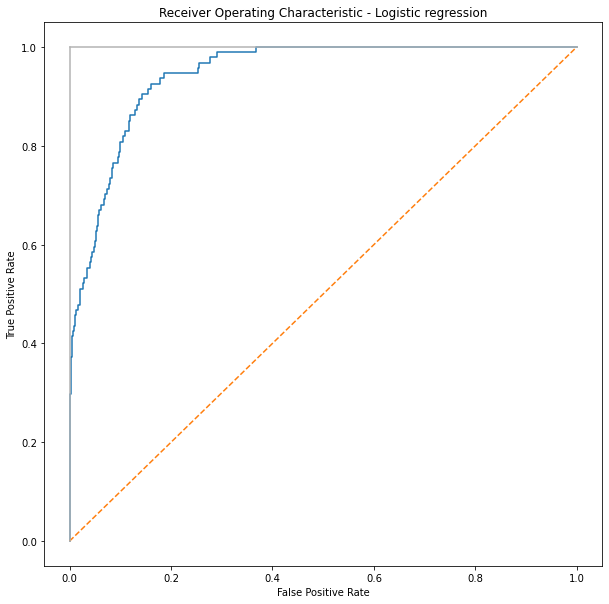

In [30]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate, true_positive_rate)

# plot y=x line
plt.plot([0, 1], ls="--")
# plot 
plt.plot(0, 1, c=".7")
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

***

### 3.2) From scratch with pandas

TPR = TP/TP+FN <br>
FPR = FP/FP+TN

In [31]:
# probabilities and thresholds
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
df_probabilities = pd.DataFrame({"True predictions": y_test, "Probability_being_1": probability_predictions})


In [32]:
true_positive_rates = []
false_positive_rates = []

total_positives = len(df_probabilities.loc[df_probabilities.loc[:, "True predictions"] == 1])
true_negatives = len(df_probabilities.loc[df_probabilities.loc[:, "True predictions"] == 0])

for index, threshold in enumerate(thresholds):
    df_probabilities.loc[:, "threshold" + str(threshold)] = df_probabilities.loc[:, "Probability_being_1"].apply(lambda x: 1 if x >= threshold else 0)
    
    true_positives = len(df_probabilities.loc[(df_probabilities.loc[:, "True predictions"] == 1) & (df_probabilities.loc[:, "threshold" + str(threshold)] == 1)])
    false_positives = len(df_probabilities.loc[(df_probabilities.loc[:, "True predictions"] == 0) & (df_probabilities.loc[:, "threshold" + str(threshold)] == 1)])
    
    true_positive_rate = true_positives / total_positives
    false_positive_rate = false_positives / (false_positives + true_negatives)
    
    true_positive_rates.append(true_positive_rate)
    false_positive_rates.append(false_positive_rate)

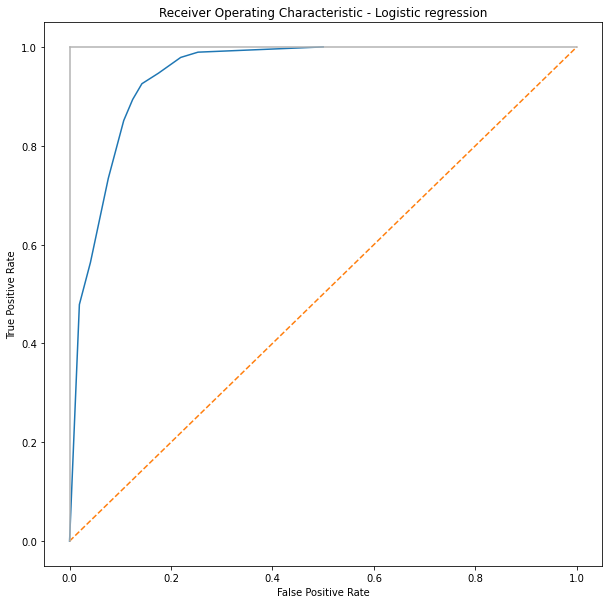

In [33]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rates, true_positive_rates)

# plot y=x line
plt.plot([0, 1], ls="--")
# plot 
# plt.plot(0, 1, c=".7")
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3) Under and over sampling